In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from qiskit import IBMQ, execute
import qiskit.tools.jupyter
from qiskit import pulse
from qiskit.pulse import pulse_lib

In [3]:
IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
provider = IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
cmd_def = pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])
config = backend.configuration()

In [5]:
anh_almaden = [-320.2, -319.7, -317.2, -320.6, -322.0, -322.5,
               -269.1, -297.1, -320.4, -325.0, -318.7, -319.5,
               -321.1, -319.8, -322.7, -325.5, -320.9, -321.3,
               -321.6, -323.0]

In [6]:
anh = anh_almaden

In [7]:
backend

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/providers/models/backendconfiguration.py:348: UserWarning: The time delta is now returned in units of [s] rather than [ns].
  warnings.warn("The time delta is now returned in units of [s] rather than [ns].")
/Users/alijavadi/Desktop/ajavadia-terra/qiskit/providers/models/backendconfiguration.py:354: UserWarning: The time delta is now returned in units of [s] rather than [ns].
  warnings.warn("The time delta is now returned in units of [s] rather than [ns].")


<IBMQBackend('alt_almaden') from IBMQ(hub='ibm-q-dev', group='qiskit-terra', project='pulse-testing')>

------------

In [8]:
MEASUREMENT_START_TIMESTEP = 500

In [9]:
# just measure
schedule0 = pulse.Schedule()
schedule0 |= measure << MEASUREMENT_START_TIMESTEP

#job = execute(schedule, backend=backend, shots=1000, meas_level=1, meas_return='single')
#print(job.job_id())

In [10]:
# X, then measure
schedule1 = pulse.Schedule()
schedule1 |= cmd_def.get('x', qubits=[0])
schedule1 |= measure << MEASUREMENT_START_TIMESTEP

#job = q.execute(schedule, backend=backend, shots=1000, meas_level=1, meas_return='single')
#print(job.job_id())

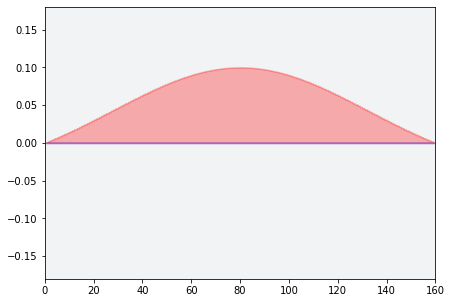

In [11]:
# Approximate X as a gaussian pulse:
DURATION = 160
AMP = 0.10
SIGMA = 52
pulse_lib.gaussian(duration=DURATION, amp=AMP, sigma=SIGMA).draw(scaling=0.18)

In [12]:
# X, then pulse at 1-2 frequency, then measure
schedule2 = pulse.Schedule()
schedule2 |= cmd_def.get('x', qubits=[0])

freq = config.dt * anh[0] * 1e6 * -1 # anharmonicity is 312 MHz. In units of dt, we have .304/ns * config.dt/ns
wave_samples = pulse.pulse_lib.cos(duration=DURATION, amp=1, freq=freq).samples - 1j * pulse.pulse_lib.sin(
            duration=DURATION, amp=1, freq=freq).samples
# use amplitude of AMP / sqrt(2) for 1->2 transition
gaussian_samples = pulse.pulse_lib.gaussian(duration=DURATION, amp=AMP / np.sqrt(2), sigma=SIGMA).samples
schedule2 |= pulse.SamplePulse(gaussian_samples * wave_samples)(config.drive(0)) << schedule2.duration

schedule2 |= measure << MEASUREMENT_START_TIMESTEP

#job = q.execute(schedule, backend=backend, shots=1000, meas_level=1, meas_return='single')
#print(job.job_id())

In [13]:
backend.status()

BackendStatus(backend_name='alt_almaden', backend_version='1.2.4', operational=True, pending_jobs=0, status_msg='active')

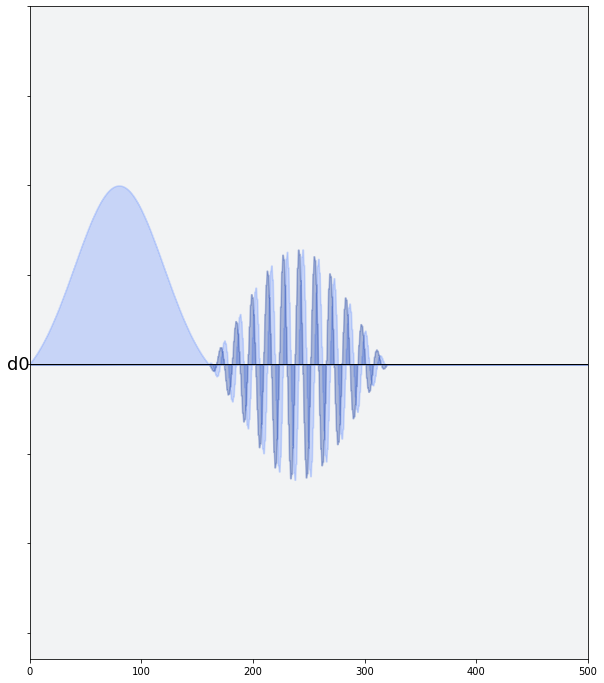

In [14]:
schedule2.draw(plot_range=[0, 500], channels_to_plot=[config.drive(0)])

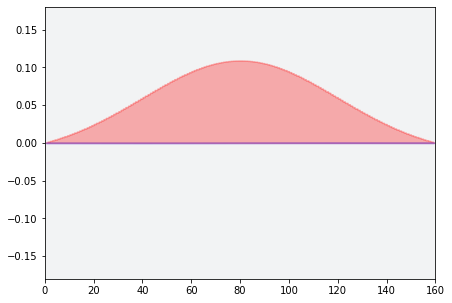

In [15]:
device_x = cmd_def.get('x', qubits=[0]).instructions[0][1].command
device_x.draw(scaling=0.18)

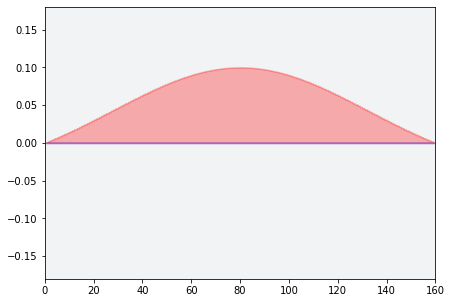

In [16]:
my_x = pulse_lib.gaussian(duration=DURATION, amp=AMP, sigma=52)
my_x.draw(scaling=0.18)

In [17]:
np.sum(my_x.samples - device_x.samples)

(0.018913720156134933+0j)

In [18]:
job = execute([schedule0, schedule1, schedule2], backend=backend, shots=1000, meas_level=1, meas_return='single')

In [27]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [26]:
backend.status()

BackendStatus(backend_name='alt_almaden', backend_version='1.2.4', operational=True, pending_jobs=0, status_msg='active')

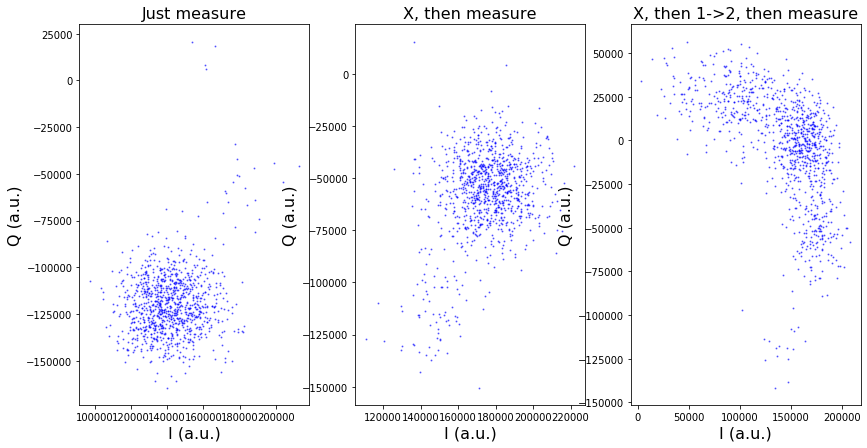

In [29]:
%matplotlib inline
fig, axes = plt.subplots(1, 3)
i = 0
fig.set_size_inches(14,7)

titles = ['Just measure', 'X, then measure', 'X, then 1->2, then measure']
result = job.result()

for (i, title) in enumerate(titles):
    memory_shots = result.get_memory(i)
    qubit_0_readouts = [memory_shot[0] for memory_shot in memory_shots]

    ax = axes[i]
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('I (a.u.)', fontsize=16)
    ax.set_ylabel('Q (a.u.)', fontsize=16)
    ax.scatter(np.real(qubit_0_readouts) * 1e-10, np.imag(qubit_0_readouts) * 1e-10,
               s=1, cmap='viridis',c='blue',alpha=0.5)
    i += 1

In [ ]:
schedule.draw(plot_range=(0, 1000))

In [ ]:
backend.properties().gates[7]

In [ ]:
import json
with open("/Users/alijavadi/Desktop/ajavadia-terra/qiskit/test/mock/config_burlington.json", "w+") as f:
    json.dump(backend.configuration().to_dict(), f)

In [ ]:
config.hamiltonian

In [30]:
backend.provider

<bound method BaseBackend.provider of <IBMQBackend('alt_almaden') from IBMQ(hub='ibm-q-dev', group='qiskit-terra', project='pulse-testing')>>